In [1]:
#!sed --help

!cat elecpy/cell/mahajan/const.py  | grep gna_
!cat elecpy/cell/mahajan/const.py  | grep gkr_
!cat elecpy/cell/mahajan/const.py  | grep gks_

!cat elecpy/cell/mahajan/kernel.c | grep "double _gtos"
!cat elecpy/cell/mahajan/kernel.c | grep "double _gtof"
!cat elecpy/cell/mahajan/kernel.c | grep "double _gca"
!cat elecpy/cell/mahajan/kernel.c | grep "double _dh ="
!cat elecpy/cell/mahajan/kernel.c | grep "double _dj ="


  'gna_'         : 12.0              , #
  'gkr_'         : 0.0125            , #
  'gks_'         : 0.1386            , #
double _gtos = {gtos_} * pow({Q10TO_}, (temp-{temp_})/10.0)*1.9;
double _gtof = {gtof_} * pow({Q10TO_}, (temp-{temp_})/10.0)*1.9;
double _gca = {gca_} * pow({Q10CAL_}, (temp-{temp_})/10.0)/1.9;
double _dh = (_ah*(1.00000-h) - _bh*h)*1.9;
double _dj = (_aj*(1.00000-j) - _bj*j)*1.9;


In [2]:

!cat elecpy/elecpy.py | grep "sigma_"


    sigma_l_i    = 1.74                  # (mS/cm)
    sigma_t_i    = 1.74                  # (mS/cm)
    sigma_l_e    = 6.25                  # (mS/cm)
    sigma_t_e    = 6.25                  # (mS/cm)
    sigma_l      = sigma_l_e + sigma_l_i
    sigma_t      = sigma_t_e + sigma_t_i
    pde_i = PDE( im_h, im_w, sigma_l_i, sigma_t_i, ds )
    pde_m = PDE( im_h, im_w, sigma_l,   sigma_t,   ds )


In [3]:
import copy
import time
import os, sys
import shutil
import json
import numpy as np

import chainer
from chainer import cuda

from matplotlib import animation, rc
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import elecpy.elecpy as elp
from elecpy.util.cmap_bipolar import bipolar
from elecpy.elecpySession import ElecpySession

from IPython.display import HTML

from opmap.videoData import VideoData
from opmap.vmemMap import VmemMap
from opmap.phaseMap import PhaseMap
from opmap.phaseVarianceMap import PhaseVarianceMap

from scipy.signal import argrelmax
from numba.decorators import autojit

%matplotlib inline


# シミュレーション実行

In [5]:
# load sample parameter
with open ('sim_params_org.json','r') as f:
    sim_params = json.load(f)

# modify parameters
sim_params['time']['end'] = 150
sim_params["stimulation"] = {}
sim_params["stimulation"] = {
    "extracellular": [
        {
            "start": 10.0, 
            "shape": [
                200, 
                200
            ], 
            "train": 1, 
            "name": "edge_L", 
            "amplitude": -30.0, 
            "duration": 20.0, 
            "interval": 200.0, 
            "size": 10
        }
    ], 
    "membrane": []
}


sim_params['log']['path'] = '/mnt/Omer/Project/01.PhaseDiscontinuity/SimulationResults/20190407-3/'
sim_params['log']['cnt'] = 1000


sim_params['geometory']['height'] = 200
sim_params['geometory']['width'] = 200

sim_params['restart']['count'] = 100
sim_params['restart']['source'] = "/mnt/Omer/Project/01.PhaseDiscontinuity/SimulationResults/20190407-1/"

print json.dumps(sim_params, indent=4)

{
    "cell_type": "mahajan", 
    "log": {
        "path": "/mnt/Omer/Project/01.PhaseDiscontinuity/SimulationResults/20190407-3/", 
        "cnt": 1000
    }, 
    "stimulation": {
        "extracellular": [
            {
                "start": 10.0, 
                "shape": [
                    200, 
                    200
                ], 
                "train": 1, 
                "name": "edge_L", 
                "amplitude": -30.0, 
                "duration": 20.0, 
                "interval": 200.0, 
                "size": 10
            }
        ], 
        "membrane": []
    }, 
    "time": {
        "end": 150, 
        "udt": 0.001
    }, 
    "geometory": {
        "width": 200, 
        "ds": 0.015, 
        "height": 200
    }, 
    "restart": {
        "count": 100, 
        "source": "/mnt/Omer/Project/01.PhaseDiscontinuity/SimulationResults/20190407-1/"
    }
}


In [6]:
g = elp.sim_generator(sim_params)

path_dst = sim_params["log"]["path"]
if not os.path.exists( path_dst ): os.mkdir( path_dst )
with open(os.path.join(path_dst, 'sim_params.json'),'w') as f: json.dump(sim_params, f, indent=4)

out = []
while True:
    img = g.next()
    if img is False: break
    out.append(np.copy(img))

elecpy simulation start!
Stimulation settings ...done
Allocating data... ...done
Initializing data... ...done
Building PDE system ... ...done
Main loop start!
------------------150.0/150mselecpy done


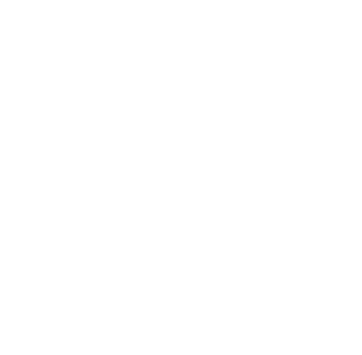

In [7]:
fig = plt.figure()
plt.axis('off')

ims = []
for img in out:
    im = plt.imshow(
        img.reshape(200,200),
        vmin = -100.0, vmax = 20.0,
        cmap=bipolar(neutral=0, lutsize=1024),
        interpolation='nearest')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims)
#ani.save('anim.gif', writer="imagemagick")
#ani.save('anim.mp4', writer="ffmpeg")
#plt.show()

HTML(ani.to_html5_video())